#### CMSE 201 Final Project
### &#9989; David Selemba
### &#9989; Section 007
#### &#9989; 12/5/2021

# MLB Reliever Usage Changes Throughout Time

(-0.5, 1199.5, 799.5, -0.5)

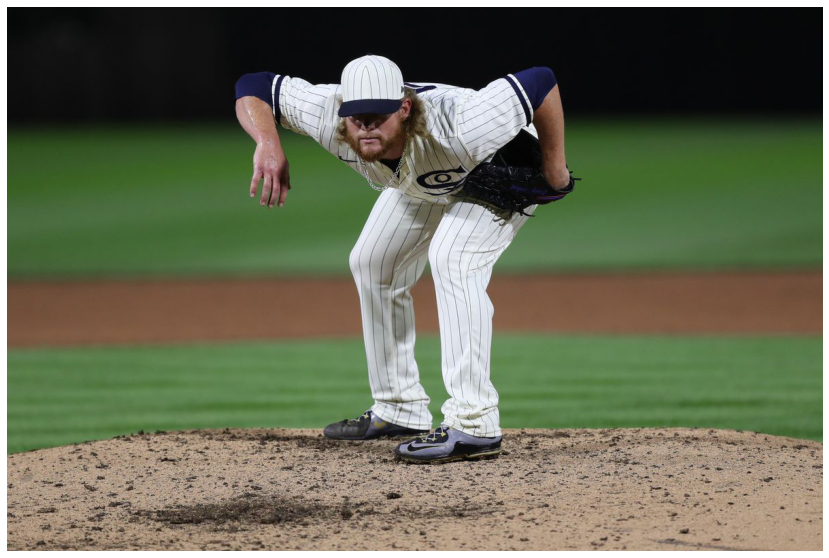

In [65]:
from PIL import Image
kimbrel = Image.open('kimbrel.jpg')
plt.figure(figsize = (20,10))
plt.imshow(kimbrel)
plt.axis('off')

## Background and Motivation

Throughout the league's history, MLB teams have continued to enhance the ways they use pitchers as insight has been gained. When the league first got it's start, starting pitchers, those who are pitching at the beginning of games, were throwing the bulk of the innings with a few relief pitchers, those who enter after the first pitcher has been removed from the game, adding a few innings here or there. Often, these pitchers only entered the game when a team had already decidedly won or lost. However, teams began to realize that as starting pitcher began to wane in stamina, it often made sense to bring in a reliever even if they may be a slightly inferior player to the starter. This was also backed by the data that showed teams that limited their teams starting pitcher usage helped the starters stay healthier and stay more effective during the postseason as they had not had their arms worn down. Often, these relievers were brought in during the 9th innings, the final of a game, and were usually the teams best relievers, becoming known as and closers. 

In recent years, especially the past 10, teams have begun to use more relievers for a greater number of innings per game. This is evidenced through the average number of pitchers used per game throughout the league, as the number has risen from just above 2.5 players in 1981 up to just under 4.5 pitchers in the recently concluded 2021 season. Much of this is in conjunction to teams looking to keep their pitchers healthy, as a rise in injuries for pitchers has occurred in recent years as well, but also due to a better understanding on how to improve relief pitcher performance. Generally, this has involved training relievers to build up greater velocity on their pitches and using them for shorter stints to maximize this. 

With so many relievers bringing varying dynamic sets of skills to teams now and less defined roles for relievers, a recent tid bit of news left me pondering a staple of the sport. During the 2021 trade deadline, the Chicago White Sox made a move to aquire Cubs closer Craig Kimbrel, one of the most accomplished closers of the past decade. They already had a top closer on the roster in his own right, Liam Hendricks, so they planned to use Kimbrel in the set-up role to create a top end duo. However, Kimbrel struggled to finish the season, posting a 5.09 ERA in 23 innings with the White Sox after putting up an 0.49 earlier in the year with the Cubs. This led to White Sox general manager Rick Hahn stating he believed much of his struggles were due to the fact that "how we used Craig didn't quite work to anyone's benefit" (Marchese). While clearly Kimbrel had more experience pitching in the final inning, I couldn't understand how his drop in performance could be accredited to this change in role. If a reliever is consistent in high leverage situations, it shouldn't matter what inning it is that they're entering, but rather than importance of the moment. With this in mind, I will attempt to answer the question of whether MLB teams are using their relievers more effectively than in the past? In addition, I will attempt to find out if less reliance on set role relievers has impacted pitchers and if this improved team success during the season. 

## Methodology

# 2.1 Importing and Cleaning Data

To start, the data that has been imported in for relievers in MLB must first be manipulated and cleaned. This data comes from a csv file with many different columns containg different statistical information, although the main data sets we will be discussing in this project are the relievers and relievers_91 sets, which contain data for all relievers who pitched at least 40 innings, 1/4 of their teams games, in the years 2021 and 1991, respectively. Some columns for each players are being concatenated to the previously dicussed sets from the leverage sets, which provide win probability and usage statistics for every reliever. While there are many variables to be discussed when talking about sucecss for pitchers, a further description of a few useful ones that will be heavily utilized throughout the basis of the data exploration below would be useful. The stats include:

- Name
- Team: (players with a dashed team played for multiple teams in one season)
- IP: innings pitched by the player
- SV: saves recorded by a player(number of appearances in which player recorded final out of a game decided by three runs or less)
- K/9: average number of strikeouts per nine innings pitched
- ERA: average number of runs allowed per nine innings pitched
- FIP: average number of runs allowed per nine innings pitched, adjusting for teams defense(Only views outcomes in which pitcher controls)
- gmLI: average "leverage" or pressure on a pitcher when entering a game
- WPA: change in team's win expectancy when a player enters
- -WPA: all negative WPA for which a player produces to their team (shows how much damage they cause when performing poorly i.e. high highs and low lows)

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
import scipy.stats
import seaborn

In [67]:
#importing reliever data for 2021
relievers = pd.read_csv('relief_data.csv', delimiter = ',')
relievers = relievers.set_index('Name')
relievers = relievers.sort_values(by = ["Name"])

In [68]:
leverage = pd.read_csv('leverage.csv', delimiter = ',')
leverage = leverage.set_index('Name')
leverage = leverage.sort_values(by = ["Name"])

#creating lists of different variables from the leverage data set to to concatenate to the relievers set
gmLI = leverage['gmLI']
wpa = leverage['WPA']
wpa_m = leverage['-WPA']
relievers = relievers.join(gmLI)
relievers = relievers.join(wpa)
relievers = relievers.join(wpa_m)
relievers = relievers.sort_values(by = ["Name"])

standard_stats = pd.read_csv('standard.csv', delimiter = ',')
standard_stats = standard_stats.set_index('Name')
standard_stats = standard_stats.sort_values(by = ["Name"])
standard_stats

hld = standard_stats['HLD']
relievers = relievers.join(hld)

#importing team statistics for later work
team_stats_21 = pd.read_csv('team.csv', delimiter = ',')
team_stats_21 = team_stats_21.set_index('Team')

In [69]:
#import team stats specifically for relievers
reliever_team_stats = pd.read_csv('reliever_team.csv', delimiter = ',')

In [70]:
relievers

,Team,W,L,SV,G,GS,IP,K/9,BB/9,HR/9,...,ERA,xERA,FIP,xFIP,WAR,playerid,gmLI,WPA,-WPA,HLD
Name,,,,,,,,,,,,,,,,,,,,,
A.J. Minter,ATL,3,6,0,61,0,52.1,9.80,3.44,0.34,...,3.78,3.01,2.69,3.81,1.3,18655,1.50,-0.62,-6.36,23
Aaron Bummer,CHW,5,5,2,62,0,56.1,11.98,4.63,0.48,...,3.51,2.70,2.96,2.80,1.2,16258,1.27,-0.62,-6.06,21
Aaron Loup,NYM,6,0,0,63,0,53.2,9.06,2.68,0.17,...,1.01,NaN,2.52,3.46,1.5,10343,1.78,1.42,-4.70,16
Adam Cimber,- - -,3,4,1,72,0,71.2,6.40,2.01,0.25,...,2.26,3.37,3.07,4.21,1.2,15288,0.92,0.39,-4.38,5
Adam Ottavino,BOS,7,3,11,69,0,62.0,10.31,5.08,0.73,...,4.21,3.71,3.96,4.70,0.5,1247,1.68,2.02,-7.91,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yency Almonte,COL,1,3,0,48,0,47.2,8.87,5.48,1.70,...,7.55,5.37,5.73,5.09,-0.5,15068,0.89,-1.25,-4.67,3
Yimi Garcia,- - -,4,9,15,62,0,57.2,9.36,2.81,1.25,...,4.21,4.45,3.88,3.76,0.4,12095,1.67,-0.24,-7.68,4
Yusmeiro Petit,OAK,8,3,2,78,0,78.0,4.27,1.38,1.38,...,3.92,4.42,4.72,5.28,0.0,4020,1.37,1.45,-5.74,22


In [71]:
# data entry
relievers_81 = pd.read_csv('relievers_81.csv', delimiter = ',')
relievers_81 = relievers_81.set_index('Name')

leverage_81 = pd.read_csv('leverage_81.csv', delimiter = ',')
leverage_81 = leverage_81.set_index('Name')

#creating lists of different variables from the leverage data set to to concatenate to the relievers_91 set
gmLI_81 = leverage_81['gmLI']
wpa_81 = leverage_81['WPA']
wpa_m_81 = leverage_81['-WPA']
relievers_81 = relievers_81.join(gmLI_81)
relievers_81 = relievers_81.join(wpa_81)
relievers_81 = relievers_81.join(wpa_m_81)
relievers_81 = relievers_81.sort_values(by = ["Name"])
relievers_81

,Team,W,L,SV,G,GS,IP,K/9,BB/9,HR/9,...,vFA (pi),ERA,xERA,FIP,xFIP,WAR,playerid,gmLI,WPA,-WPA
Name,,,,,,,,,,,,,,,,,,,,,
Al Holland,SFG,6,5,7,44,0,79.0,6.95,4.33,0.34,...,NaN,2.51,NaN,3.07,NaN,0.5,1005947,1.47,1.54,-6.65
Andy Hassler,CAL,4,3,5,42,0,75.2,5.23,3.93,0.95,...,NaN,3.21,NaN,4.12,NaN,-0.2,1005480,1.56,-0.30,-5.58
Aurelio Lopez,DET,3,1,3,26,0,66.1,5.83,3.53,0.81,...,NaN,3.39,NaN,3.75,NaN,0.3,1007753,1.22,-0.29,-3.44
Bill Campbell,BOS,1,1,7,30,0,48.1,6.89,3.72,0.93,...,NaN,3.17,NaN,3.66,NaN,0.2,1001874,1.19,0.05,-3.21
Bill Lee,MON,3,3,6,24,0,43.1,2.70,1.45,0.62,...,NaN,1.87,NaN,3.52,NaN,0.1,1007448,1.78,1.30,-3.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tippy Martinez,BAL,3,3,11,37,0,59.0,7.63,4.88,0.61,...,NaN,2.90,NaN,3.41,NaN,0.6,1008200,2.22,0.92,-5.97
Tom Burgmeier,BOS,4,5,6,32,0,59.2,5.28,2.56,0.75,...,NaN,2.87,NaN,3.57,NaN,0.4,1001668,1.97,0.55,-6.05
Tom Hume,CIN,9,4,13,51,0,67.2,3.59,4.12,0.93,...,NaN,3.46,NaN,4.57,NaN,-1.0,1006179,1.77,1.22,-7.04


# 2.2 Closers and Set-Up Guys

Part of this project will focus specifically on players with set roles in their teams relief pitching plans, so we will need to create a seperate data frame for only the players who apply to this. Those who reached at least ten saves are likely to have what is considered a "closer" role, so for this study these are our subjects.

In [72]:
#Masks to create a data set for all pitchers who identified as closers by achieving 10 or more saves in 2021
closers = relievers[relievers['SV'] >= 5]
#Masks to create a data set for all pitchers who identified as closers by achieving 10 or more saves in 1991
closers_81 = relievers_81[relievers_81['SV'] >= 5]

closers.head()

,Team,W,L,SV,G,GS,IP,K/9,BB/9,HR/9,...,ERA,xERA,FIP,xFIP,WAR,playerid,gmLI,WPA,-WPA,HLD
Name,,,,,,,,,,,,,,,,,,,,,
Adam Ottavino,BOS,7,3,11,69,0,62.0,10.31,5.08,0.73,...,4.21,3.71,3.96,4.70,0.5,1247,1.68,2.02,-7.91,22
Alex Colome,MIN,4,4,17,67,0,65.0,8.03,3.18,1.11,...,4.15,4.79,4.23,4.21,0.1,6661,1.33,-1.10,-8.93,5
Alex Reyes,STL,10,8,29,69,0,72.1,11.82,6.47,1.12,...,3.24,3.55,4.40,4.56,0.2,15015,1.51,-0.29,-10.06,3
Amir Garrett,CIN,0,4,7,63,0,47.2,11.52,5.48,1.70,...,6.04,4.45,4.89,4.03,-0.1,14375,1.27,-0.14,-4.78,7
Andrew Chafin,- - -,2,4,5,71,0,68.2,8.39,2.49,0.52,...,1.83,3.01,2.98,4.00,1.4,12988,1.40,2.67,-4.62,22


In [73]:
closers_81.head()

,Team,W,L,SV,G,GS,IP,K/9,BB/9,HR/9,...,vFA (pi),ERA,xERA,FIP,xFIP,WAR,playerid,gmLI,WPA,-WPA
Name,,,,,,,,,,,,,,,,,,,,,
Al Holland,SFG,6,5,7,44,0,79.0,6.95,4.33,0.34,...,NaN,2.51,NaN,3.07,NaN,0.5,1005947,1.47,1.54,-6.65
Andy Hassler,CAL,4,3,5,42,0,75.2,5.23,3.93,0.95,...,NaN,3.21,NaN,4.12,NaN,-0.2,1005480,1.56,-0.30,-5.58
Bill Campbell,BOS,1,1,7,30,0,48.1,6.89,3.72,0.93,...,NaN,3.17,NaN,3.66,NaN,0.2,1001874,1.19,0.05,-3.21
Bill Lee,MON,3,3,6,24,0,43.1,2.70,1.45,0.62,...,NaN,1.87,NaN,3.52,NaN,0.1,1007448,1.78,1.30,-3.76
Bobby Castillo,LAD,2,4,5,33,0,45.2,6.31,4.34,0.79,...,NaN,5.52,NaN,3.78,NaN,-0.1,1002057,1.42,-0.68,-4.30


# 2.3 Performance Consistency Function

In [74]:
#use descriptive statsitics for innings pitched column to be used in the function
relievers['IP'].describe()

count    191.000000
mean      57.367016
std       10.351202
min       40.000000
25%       48.600000
50%       57.100000
75%       64.200000
max       83.200000
Name: IP, dtype: float64

When looking to find the pitchers best suited to be pitching in the highest leverage situations, the most important attribute is consistency that the reliever can bring to their team when playing. While no statistic already exists to capture this, we can use some statsitics from the data sets that can predict which players will be most consistent based on correlation. Clearly, win probability is important to being a consistent pitcher, as production that leads to success is extremely vital. However, it is important to adjust slightly for how poor a pitchers bad outings can be, as pitchers who have a high negative win probability could lose games that should be won handidly. In addition, innings pitched is a vital part of consistency, as those are able to keep up their sucess at the same level as a season goes on are even more valuable than those who cannot stay healthy. Finally, strikeouts are vital part of consistency as they are the only positive outcome for pitchers that are not impacted by defense. While the pitchers trust their defense, they can only control things within themselves, so in order to insure no miscues take place, strikeouts are vital. Players who are in the top 20% of the league for the variables will have their consistency boosted, as these are key factors when considering our new stat.

In [75]:
#creating a consistency function for player performance with win probability, negaitve WPA, innings pitched, and K/9 as inputs
def consistency_value(wpa, wpa_minus, ip, k9):
    win_prob = wpa - (wpa_minus * 0.15)  #defines win probability while adjusting for players with signifgantly low lows
    for i in ip:
        if i >= 64.2:  #condition based on if player is in the top 20% of innings pitched
            consistency = win_prob + 0.25
    for i in k9:
        if i >= 10.975:  #condition based on if player is in the top 20% of K/9
            consistency = win_prob + 0.5
    return consistency

## Results

# 3.1.1 Overall Results

In [76]:
#uses function created above to make consistency values for each player in the 2021 set using dataframe columns
winner = consistency_value(leverage['WPA'], leverage['-WPA'], relievers['IP'], relievers['K/9'])
relievers['consistency'] = winner
relievers.sort_values(by = ['consistency'])

print(winner)
print("The average consistency value for relievers in 2021 was", np.mean(winner))

Name
A.J. Minter       0.8340
Aaron Bummer      0.7890
Aaron Loup        2.6250
Adam Cimber       1.5470
Adam Ottavino     3.7065
                   ...  
Yency Almonte    -0.0495
Yimi Garcia       1.4120
Yusmeiro Petit    2.8110
Zach Pop         -0.2280
Zack Littell      2.4190
Length: 191, dtype: float64
The average consistency value for relievers in 2021 was 1.831937172774869


Text(0.5, 0.98, 'Leverage index and consistency, 2021, by team')

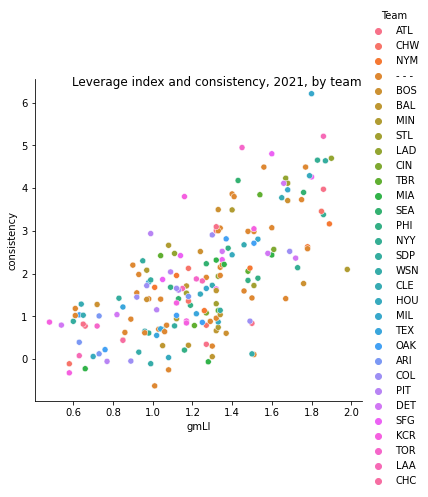

In [77]:
graph1 = seaborn.relplot(data = relievers, x = 'gmLI', y = 'consistency', hue  = 'Team')
graph1.fig.suptitle('Leverage index and consistency, 2021, by team')

Using data frame values from relievers to calculate consistency, we can obtain values for each player and graph the values with regards to their correlation to leverage index when entering the game. This shows there is a positive relationship between the two variables.

In [78]:
#uses function created above to make consistency values for each player in the 1991 set using dataframe columns
win_81 = consistency_value(leverage_81['WPA'], leverage_81['-WPA'], relievers_81['IP'], relievers_81['K/9'])
relievers_81['consistency'] = win_81
relievers_81.sort_values(by = ['consistency'])
print(win_81)
print("The average consistency value for relievers in 1991 was", np.mean(win_81))

Name
Rollie Fingers     4.9140
Jeff Reardon       3.2245
La Marr Hoyt       3.2855
Dan Quisenberry    3.3815
Don Aase           2.9380
                    ...  
Dick Tidrow        0.7395
John Urrea        -0.0910
Sparky Lyle        0.1665
Gene Garber       -0.2440
Doug Corbett       0.2515
Length: 79, dtype: float64
The average consistency value for relievers in 1991 was 1.332145569620253


Text(0.5, 0.98, 'Leverage index and consistency, 1981, by team')

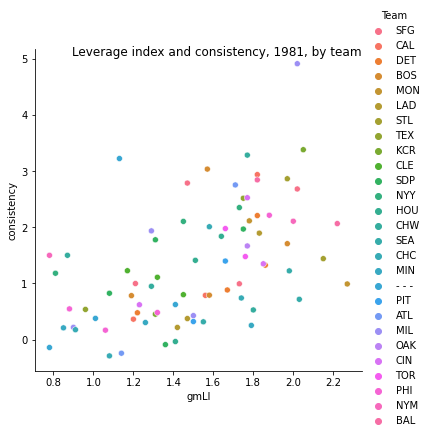

In [79]:
graph2 = seaborn.relplot(data = relievers_81, x = 'gmLI', y = 'consistency', hue  = 'Team')
graph2.fig.suptitle('Leverage index and consistency, 1981, by team')

The graph for 1991 relievers also has a slightly positive relationship, although the spread of data points makes this less strong than in 2021. However, we will need more evidence to suggest this stronger relationship that would suggest relievers are being use more optimally in 2021.

In [80]:
#calculating correlation values between two variables for the season as whole, consistency and gmLI, using pearsonr, which is a correlation function of scipy
correlation_21 = scipy.stats.pearsonr(relievers['consistency'], relievers['gmLI'])[0]
correlation_81 = scipy.stats.pearsonr(relievers_81['consistency'], relievers_81['gmLI'])[0]

print("The average correlation between leverage a picther is used in based on pitcher consistency in 2021 is", round(correlation_21, 2))
print("The average correlation between leverage a picther is used in based on pitcher consistency in 1981 is", round(correlation_81, 2))

The average correlation between leverage a picther is used in based on pitcher consistency in 2021 is 0.68
The average correlation between leverage a picther is used in based on pitcher consistency in 1981 is 0.52


# 3.1.2 Optimizing Consistency and Leverage using Fitting

In [81]:
#creating a first order linear regression for the relationship between leverage when entering and consistency
parameters = np.polyfit(relievers['gmLI'], relievers['consistency'], 2)
func = np.poly1d(parameters)
x_array_21 = np.linspace(min(relievers['gmLI']), max(relievers['gmLI']), 191)
x_array_81 = np.linspace(min(relievers_81['gmLI']), max(relievers_81['gmLI']), 79)
expected_y_21 = func(x_array_21)
expected_y_81 = func(x_array_81)

By fitting the data, we can better evalute the usage of relievers in each season. The curve shows there is a strong positive correlation between 2021 leverage at the entrance of a game and their consistency stat, meaning that teams are using their best relievers in the most optimal moments. However, in 1991, we see more data points below the curve than above, which would indicate that some lesser players were pitching in moments that may have been too important for them to decide.

Text(0.5, 1.0, 'Leverage index and consitency, 1981')

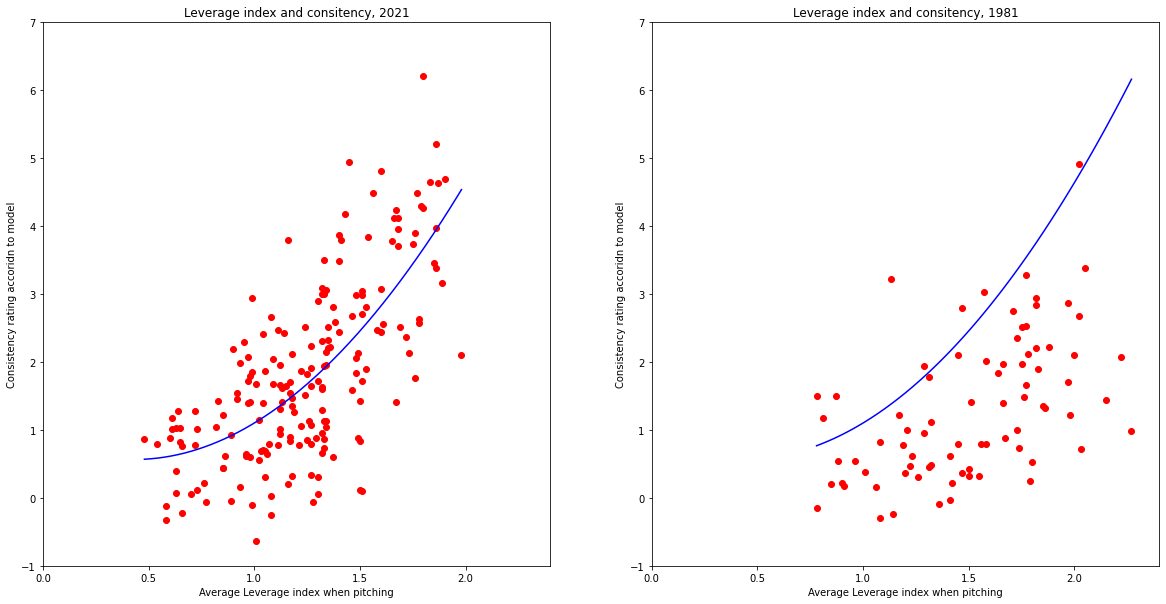

In [82]:
#fitted plots for leverage index vs consistency using first order linear regression
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.scatter(relievers['gmLI'], relievers['consistency'],c = 'red')
plt.plot(x_array_21, expected_y_21, color = 'blue')
plt.xlim(left = 0)
plt.xlim(right = 2.4)
plt.ylim(bottom = -1)
plt.ylim(top = 7)
plt.xlabel("Average Leverage index when pitching")
plt.ylabel("Consistency rating accoridn to model")
plt.title("Leverage index and consitency, 2021")

plt.subplot(1,2,2)
plt.scatter(relievers_81['gmLI'], relievers_81['consistency'], c = 'red')
plt.plot(x_array_81, expected_y_81, color = 'blue')
plt.xlim(left = 0)
plt.xlim(right = 2.4)
plt.ylim(bottom = -1)
plt.ylim(top = 7)
plt.xlabel("Average Leverage index when pitching")
plt.ylabel("Consistency rating accoridn to model")
plt.title("Leverage index and consitency, 1981")

# 3.2 Set Role Pitchers Results

Text(0.5, 1.0, 'Closer FIP 1981')

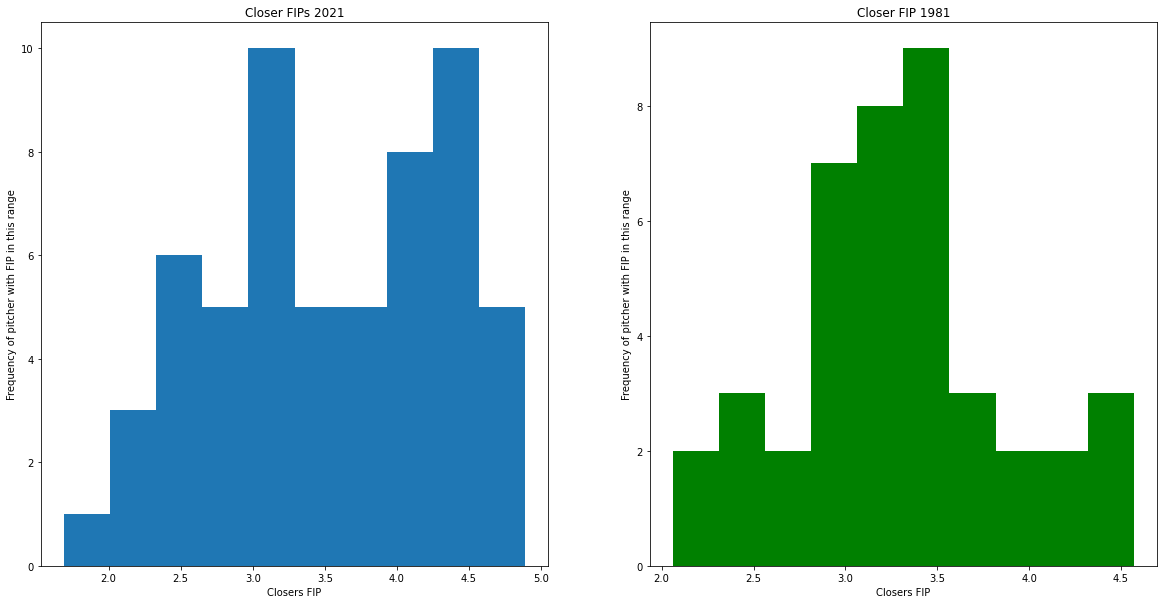

In [83]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.hist(closers['FIP'])
plt.xlabel("Closers FIP")
plt.ylabel("Frequency of pitcher with FIP in this range")
plt.title("Closer FIPs 2021")

plt.subplot(1,2,2)
plt.hist(closers_81['FIP'], color ='green')
plt.xlabel("Closers FIP")
plt.ylabel("Frequency of pitcher with FIP in this range")
plt.title("Closer FIP 1981")

By taking a quick glimpse at the closers from both season, it is easy to pick out that there is a much greater range of FIP values for closers in the modern game in comparison to 1981. This alone signals that teams are using a wider array of players late in games instead of using a set player, so their decision making is much more matchup based. While it is odd to see a near skew left for 2021, as this would mean many closers were allowing a signifigant amount of runs, there are many other factors to consider if we are truly to believe this change is meaningful.

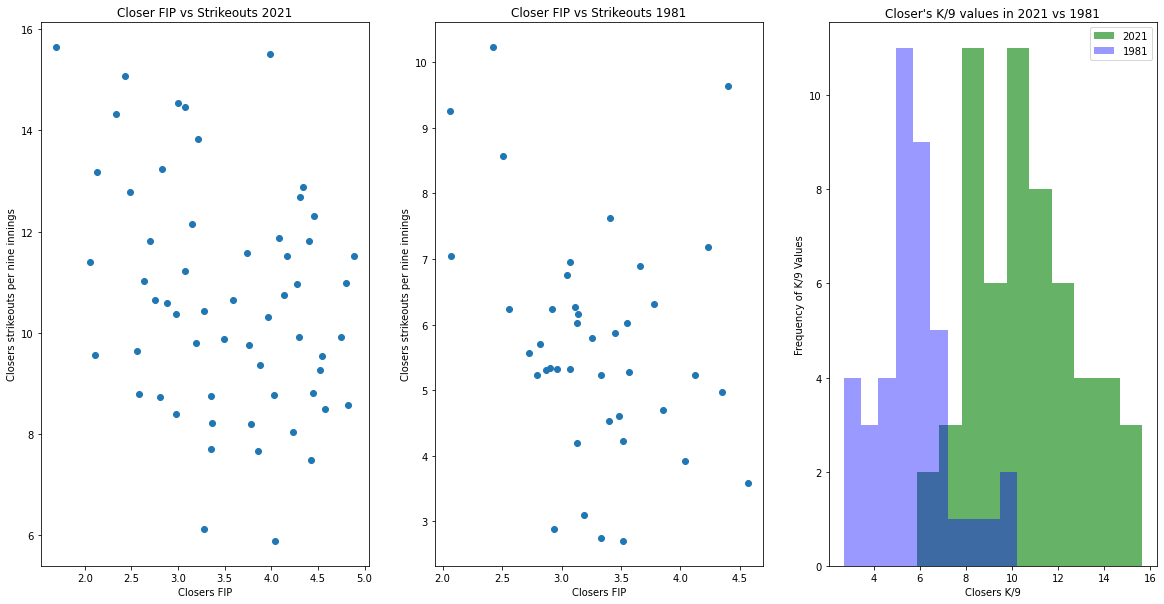

In [84]:
plt.figure(figsize = (20,10))
plt.subplot(1,3,1)
plt.scatter(closers['FIP'], closers['K/9'])
plt.xlabel("Closers FIP")
plt.ylabel("Closers strikeouts per nine innings")
plt.title("Closer FIP vs Strikeouts 2021")

plt.subplot(1,3,2)
plt.scatter(closers_81['FIP'], closers_81['K/9'])
plt.xlabel("Closers FIP")
plt.ylabel("Closers strikeouts per nine innings")
plt.title("Closer FIP vs Strikeouts 1981")

plt.subplot(1,3,3)
plt.hist(closers['K/9'], color = 'green', alpha =0.6, label = "2021")
plt.hist(closers_81['K/9'], color = 'blue', alpha = 0.4, label = "1981")
plt.xlabel("Closers K/9")
plt.ylabel("Frequency of K/9 Values")
plt.title("Closer's K/9 values in 2021 vs 1981")
plt.legend()

By plotting a pitcher's FIP, or runs allowed per nine innings adjusted for fielding errors, in comparison to their strikeouts per nine innings, we can see there is a much greater reliance on strikeouts for relievers in 2021. The frequency of high K/9 values, as seen in the third graph, has incresed substantially in 40 years. While this may not improve overall player performance throughout the season, as those who rely on strikeouts may struggle more than others on their off nights since the ball is not going into play, this could signal an explanation for what is causing more consistency in lesser pitchers getting teams out of difficult situations in games. Even if a pitcher may not be the best on their team, consistenly getting strikeouts can help teams escape jams in which any ball in play would concede a run, so they are still especially valuable to teams as they effectively get them through tough moments in the game, even if they may have rocky outings here and there.

In [85]:
c_win_21 = consistency_value(closers['WPA'], closers['-WPA'], closers['IP'], closers['K/9'])  #using consistency function for 2021 closer set
closers['consistency'] = c_win_21
closers.sort_values(by = ['consistency'])

c_win_81 = consistency_value(closers_81['WPA'], closers_81['-WPA'], closers_81['IP'], closers_81['K/9'])  #using consistency function to carry out values for 1981 closers
closers_81['consistency'] = c_win_81
closers_81.sort_values(by = ['consistency'])

<ipython-input-85-6b49e009f57e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closers['consistency'] = c_win_21
<ipython-input-85-6b49e009f57e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closers_81['consistency'] = c_win_81


,Team,W,L,SV,G,GS,IP,K/9,BB/9,HR/9,...,ERA,xERA,FIP,xFIP,WAR,playerid,gmLI,WPA,-WPA,consistency
Name,,,,,,,,,,,,,,,,,,,,,
Frank LaCorte,HOU,4,2,5,37,0,42.0,8.57,4.50,0.21,...,3.64,NaN,2.51,NaN,0.6,1007239,1.41,-0.96,-4.49,-0.0365
Bobby Castillo,LAD,2,4,5,33,0,45.2,6.31,4.34,0.79,...,5.52,NaN,3.78,NaN,-0.1,1002057,1.42,-0.68,-4.30,0.2150
Doug Corbett,MIN,2,6,17,54,0,87.2,6.16,3.49,0.51,...,2.57,NaN,3.14,NaN,1.2,1002608,1.79,-1.68,-11.21,0.2515
Larry Andersen,SEA,3,3,5,41,0,67.2,5.32,2.39,0.53,...,2.66,NaN,3.07,NaN,1.1,1000236,1.55,-0.73,-5.30,0.3150
Enrique Romo,PIT,1,3,9,33,0,41.2,4.97,3.89,1.08,...,4.54,NaN,4.35,NaN,-0.4,1011175,1.50,-0.56,-4.20,0.3200
Dave Stewart,LAD,4,3,6,32,0,43.1,6.02,2.91,0.62,...,2.49,NaN,3.13,NaN,0.3,1012519,1.47,-0.54,-4.42,0.3730
Ron Reed,PHI,5,3,8,39,0,61.1,5.87,2.49,0.88,...,3.08,NaN,3.45,NaN,0.2,1010773,1.32,-0.56,-5.27,0.4805
Ed Farmer,CHW,3,3,10,42,0,52.2,7.18,5.81,0.85,...,4.61,NaN,4.23,NaN,-0.3,1003935,1.80,-0.76,-6.91,0.5265
Dick Drago,SEA,4,6,5,39,0,53.2,4.53,2.52,0.67,...,5.53,NaN,3.40,NaN,0.8,1003475,2.03,-0.48,-6.31,0.7165


Text(0.5, 0.98, 'Leverage index and consistency, closers 2021, by team')

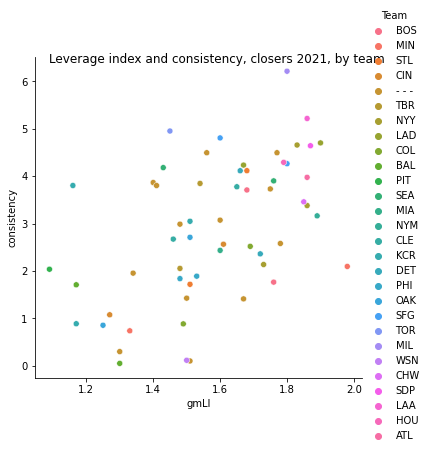

In [86]:
closers1 = seaborn.relplot(data = closers, x = 'gmLI', y = 'consistency', hue  = 'Team')
closers1.fig.suptitle('Leverage index and consistency, closers 2021, by team')

Text(0.5, 0.98, 'Leverage index and consistency, closers 1981, by team')

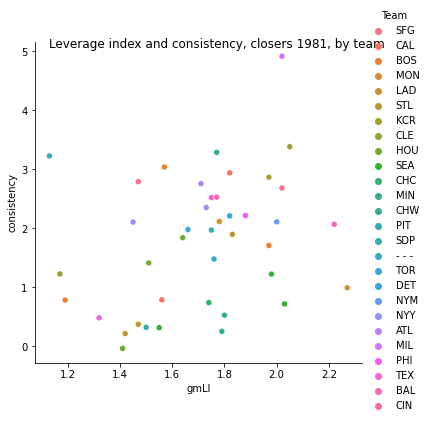

In [87]:
closers2 = seaborn.relplot(data = closers_81, x = 'gmLI', y = 'consistency', hue  = 'Team')
closers2.fig.suptitle('Leverage index and consistency, closers 1981, by team')

After finding consistency values for every closer in both seasons, I once again aimed to find if there was a relationship between consistency and gmLI. Unsurprisingly, there was a much stronger relationship in 2021 in comparison to 1981 in regards to a players consistency and their leverage index usage for all players established as closers, as this follows the pattern we saw above in the overall results. Albeit, both relationships are not signifcantly strong in either plot. However, this does show us that there is very little reason for a team to ever give a player a set role, as it is more optimal to use pitchers based on matchups with regards to their individual strengths. So, while we cannot determine if undefined roles improve player by player performance, due to the rise in closer FIP values, we can at least see that this methodology can improve teams as a whole.

# 3.3 Pitcher Usage and Team Success

By maksing for each team individually, I was able to find correlation values between the each teams relievers leverage index and their consistency values. I did this using scipy's stats function pearsonr, which shows correlation between two sets of variables. A strong correlation value would signal that a team is using their relievers more effectively, while a low value would signal that improvements could made. This will be impacted some by teams that have better pitching than others, as oit could make poor decision making managers look better even if they aren't using the bullpen optimally. In addition, since some teams had more relievers used than others, there may some error to account for as this could cause outlier values. Still, it will allow for me to look at if there is any relationship between team sucess and reliever effectiveness in some fashion, which could be very important in evaluating staff members.

In [88]:
team_stats_21 = team_stats_21.sort_values(by = ["Team"])

team_correlations = []  #empty list of team correlation values to be added to
relievers['Team']['Craig Kimbrel'] = 'CHC'

ari = relievers[relievers['Team'] == "ARI"]  #mask based on team condition
ari_cor = scipy.stats.pearsonr(ari['gmLI'], ari['consistency'])[0]  #take correlation between leverage when entering and consistency
team_correlations.append(ari_cor)  #append to the empty list

atl = relievers[relievers['Team'] == "ATL"]  #carry out same process for each team
atl_cor = scipy.stats.pearsonr(atl['gmLI'], atl['consistency'])[0]
team_correlations.append(atl_cor)

bal = relievers[relievers['Team'] == "BAL"]
bal_cor = scipy.stats.pearsonr(bal['gmLI'], bal['consistency'])[0]
team_correlations.append(bal_cor)

bos = relievers[relievers['Team'] == "BOS"]
bos_cor = scipy.stats.pearsonr(bos['gmLI'], bos['consistency'])[0]
team_correlations.append(bos_cor)

chc = relievers[relievers['Team'] == "CHC"]
chc_cor = scipy.stats.pearsonr(chc['gmLI'], chc['consistency'])[0]
team_correlations.append(chc_cor)

cws = relievers[relievers['Team'] == "CHW"]
cws_cor = scipy.stats.pearsonr(cws['gmLI'], cws['consistency'])[0]
team_correlations.append(cws_cor)

cin = relievers[relievers['Team'] == "CIN"]
cin_cor = scipy.stats.pearsonr(cin['gmLI'], cin['consistency'])[0]
team_correlations.append(cin_cor)

cle = relievers[relievers['Team'] == "CLE"]
cle_cor = scipy.stats.pearsonr(cle['gmLI'], cle['consistency'])[0]
team_correlations.append(cle_cor)

col = relievers[relievers['Team'] == "COL"]
col_cor = scipy.stats.pearsonr(col['gmLI'], col['consistency'])[0]
team_correlations.append(col_cor)

det = relievers[relievers['Team'] == "DET"]
det_cor = scipy.stats.pearsonr(det['gmLI'], det['consistency'])[0]
team_correlations.append(det_cor)

hou = relievers[relievers['Team'] == "HOU"]
hou_cor = scipy.stats.pearsonr(hou['gmLI'], hou['consistency'])[0]
team_correlations.append(hou_cor)

kcr = relievers[relievers['Team'] == "KCR"]
kcr_cor = scipy.stats.pearsonr(kcr['gmLI'], kcr['consistency'])[0]
team_correlations.append(kcr_cor)

laa = relievers[relievers['Team'] == "LAA"]
laa_cor = scipy.stats.pearsonr(laa['gmLI'], laa['consistency'])[0]
team_correlations.append(laa_cor)

lad = relievers[relievers['Team'] == "LAD"]
lad_cor = scipy.stats.pearsonr(lad['gmLI'], lad['consistency'])[0]
team_correlations.append(lad_cor)

mia = relievers[relievers['Team'] == "MIA"]
mia_cor = scipy.stats.pearsonr(mia['gmLI'], mia['consistency'])[0]
team_correlations.append(mia_cor)

mil = relievers[relievers['Team'] == "MIL"]
mil_cor = scipy.stats.pearsonr(mil['gmLI'], mil['consistency'])[0]
team_correlations.append(mil_cor)

minn = relievers[relievers['Team'] == "MIN"]
minn_cor = scipy.stats.pearsonr(minn['gmLI'], minn['consistency'])[0]
team_correlations.append(minn_cor)

nym = relievers[relievers['Team'] == "NYM"]
nym_cor = scipy.stats.pearsonr(nym['gmLI'], nym['consistency'])[0]
team_correlations.append(nym_cor)

nyy = relievers[relievers['Team'] == "NYY"]
nyy_cor = scipy.stats.pearsonr(nyy['gmLI'], nyy['consistency'])[0]
team_correlations.append(nyy_cor)

oak = relievers[relievers['Team'] == "OAK"]
oak_cor = scipy.stats.pearsonr(oak['gmLI'], oak['consistency'])[0]
team_correlations.append(oak_cor)

phi = relievers[relievers['Team'] == "PHI"]
phi_cor = scipy.stats.pearsonr(phi['gmLI'], phi['consistency'])[0]
team_correlations.append(phi_cor)

pit = relievers[relievers['Team'] == "PIT"]
pit_cor = scipy.stats.pearsonr(pit['gmLI'], pit['consistency'])[0]
team_correlations.append(pit_cor)

sdp = relievers[relievers['Team'] == "SDP"]
sdp_cor = scipy.stats.pearsonr(sdp['gmLI'], sdp['consistency'])[0]
team_correlations.append(sdp_cor)

sea = relievers[relievers['Team'] == "SEA"]
sea_cor = scipy.stats.pearsonr(sea['gmLI'], sea['consistency'])[0]
team_correlations.append(sea_cor)

sfg = relievers[relievers['Team'] == "SFG"]
sfg_cor = scipy.stats.pearsonr(sfg['gmLI'], sfg['consistency'])[0]
team_correlations.append(sfg_cor)

stl = relievers[relievers['Team'] == "STL"]
stl_cor = scipy.stats.pearsonr(stl['gmLI'], stl['consistency'])[0]
team_correlations.append(stl_cor)

tbr = relievers[relievers['Team'] == "TBR"]
tbr_cor = scipy.stats.pearsonr(tbr['gmLI'], tbr['consistency'])[0]
team_correlations.append(tbr_cor)

tex = relievers[relievers['Team'] == "TEX"]
tex_cor = scipy.stats.pearsonr(tex['gmLI'], tex['consistency'])[0]
team_correlations.append(tex_cor)

tor = relievers[relievers['Team'] == "TOR"]
tor_cor = scipy.stats.pearsonr(tor['gmLI'], tor['consistency'])[0]
team_correlations.append(tor_cor)

wsn = relievers[relievers['Team'] == "WSN"]
wsn_cor = scipy.stats.pearsonr(wsn['gmLI'], wsn['consistency'])[0]
team_correlations.append(wsn_cor)


<ipython-input-88-a85e7879e6f1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relievers['Team']['Craig Kimbrel'] = 'CHC'


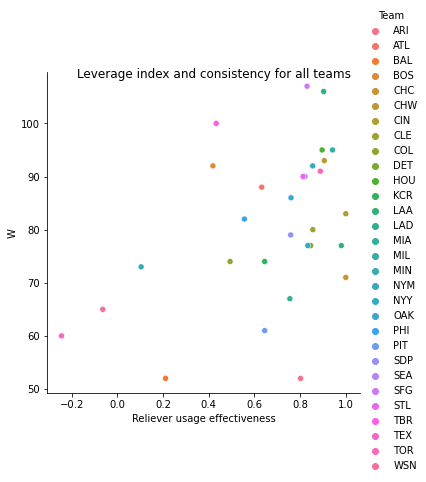

In [89]:
graph3 = seaborn.relplot(data = team_stats_21, x = team_correlations, y = 'W', hue  = 'Team')
graph3.fig.suptitle('Leverage index and consistency for all teams')
graph3.set_xlabels("Reliever usage effectiveness")

In [90]:
team_stats_21['usage effectiveness'] = team_correlations  #adds usage effectiveness values to datas set
team_stats_21.sort_values(by = ['W'])  # sorts by win to see how effectiveness shifts as record improves

,W,L,SV,G,GS,IP,K/9,BB/9,HR/9,BABIP,LOB%,GB%,HR/FB,vFA (pi),ERA,xERA,FIP,xFIP,WAR,usage effectiveness
Team,,,,,,,,,,,,,,,,,,,,
ARI,52,110,22,727,162,1417.1,7.86,3.52,1.47,0.299,68.2%,40.2%,13.8%,92.2,5.15,NaN,4.88,4.85,4.0,0.801737
BAL,52,110,26,731,162,1402.0,7.92,3.61,1.66,0.305,66.7%,39.7%,15.1%,92.9,5.85,NaN,5.15,4.91,7.9,0.210461
TEX,60,102,31,669,162,1424.1,7.83,3.24,1.47,0.288,70.3%,42.4%,14.9%,93.6,4.80,NaN,4.76,4.57,4.5,-0.244983
PIT,61,101,25,745,162,1396.1,8.46,3.91,1.37,0.302,70.1%,40.9%,13.8%,93.4,5.08,NaN,4.74,4.70,5.0,0.644799
WSN,65,97,36,731,162,1394.1,8.69,3.54,1.59,0.289,71.0%,41.0%,16.0%,93.3,4.82,NaN,4.87,4.53,6.5,-0.064380
MIA,67,95,33,757,162,1415.0,8.78,3.36,1.03,0.290,71.6%,44.6%,12.0%,93.8,3.96,NaN,4.01,4.21,15.1,0.754983
CHC,71,91,40,761,162,1412.2,8.65,3.80,1.50,0.294,70.9%,44.8%,17.2%,93.0,4.88,NaN,4.88,4.43,4.9,1.000000
MIN,73,89,42,691,162,1419.1,8.35,3.07,1.52,0.290,68.9%,41.0%,15.0%,92.2,4.83,NaN,4.66,4.44,8.2,0.103675
COL,74,87,33,704,161,1397.0,8.18,3.47,1.26,0.302,69.8%,44.8%,14.3%,94.5,4.83,NaN,4.47,4.38,13.3,0.493130


# 3.4 Other Meaningful Statistical Relationships

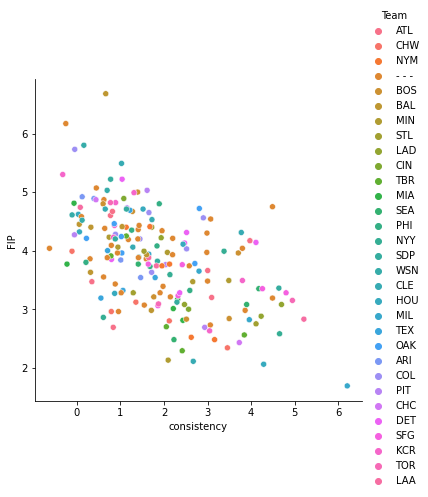

In [91]:
seaborn.relplot(data = relievers, x = 'consistency', y = 'FIP', hue  = 'Team')

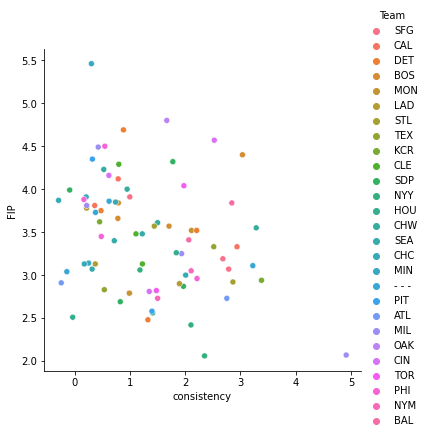

In [92]:
seaborn.relplot(data = relievers_81, x = 'consistency', y = 'FIP', hue  = 'Team')

These graphs both show that there is a strong negative relationship between consistency and FIP, which means that generally more conistent relievers will perform strongly result wise for their team. This adds to the validity of the consistency statistics, as the best relievers tend to have a strong consistency mark.

Text(0.5, 1.0, 'Team by team FIP breakdown')

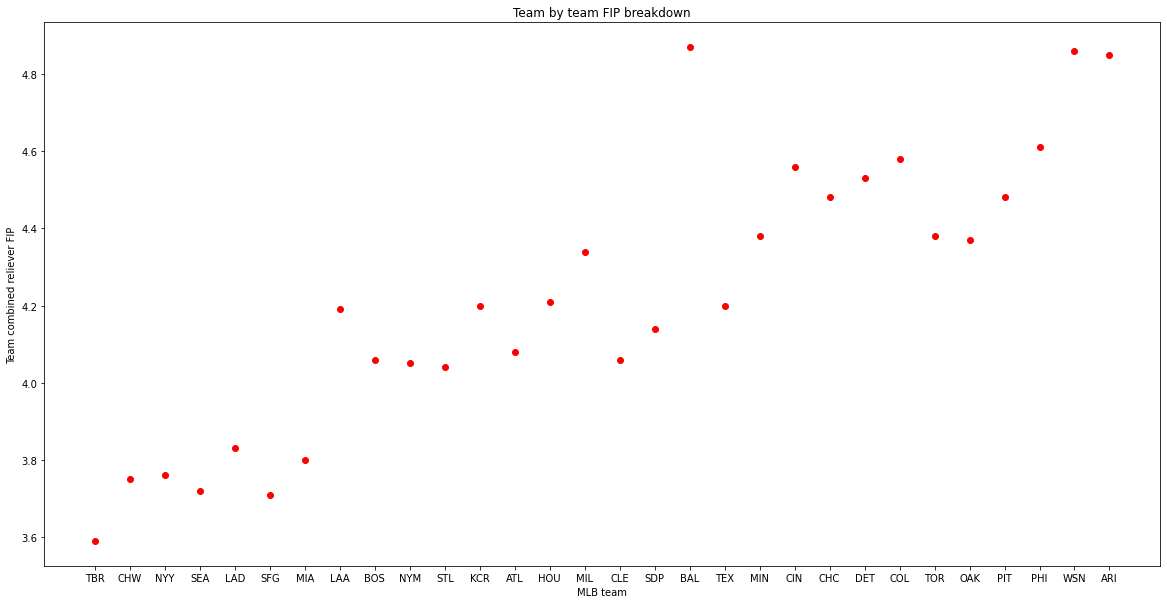

In [93]:
plt.figure(figsize = (20,10))
plt.scatter(reliever_team_stats['Team'], reliever_team_stats['FIP'], c = 'red')
plt.xlabel("MLB team")
plt.ylabel("Team combined reliever FIP")
plt.title("Team by team FIP breakdown")

This plot illustrates how each teams bullpen faired as a whole based on their FIP. This further illustrates how some managers hold an advantage in decision making in leverage situations as they have stronger depth of relievers as a whole. However, it also shows that some playoff teams had bullpens that did not fair well overall but still managed to make decisions well enough to earn a postseason berth, furthering the point of effectiveness of usage.

## Discussion and Conclusion

After going through the data analysis, the results have shown me that overall, MLB teams have begun to use their relievers in a more effective manner than in the past. This is evidenced in the fact that the correlation between relief pitcher's leverage index when entering a game based on their consistency in performance was strengthened from 0.58 in 1991 to 0.68 in 2021. What makes this especially surprising is that this occured while teams have begun to rely more heavily on relievers, as despite an 80% increase in the number of pitchers used per game through this 40 year window, the average consistency value for pitchers have improved 37.5% in that time. It is hard to believe that a greater number of relievers would actually improve results as it would seem teams wouldn't let great players go unnoticed. However, this rise in effectiveness is likely due in part to managers using these valuable statistics in their decision making, which they had done very little of in the past, as they are putting their players in roles they're best fit for. In addition, advances in training cannot go unnoticed when discussing the improvement of relievers during this time period. 

The team by team results were also quite interesting, as although some error that was discussed based on teams holding a competitive advantage playing a part, these effectiveness values through correlation could be useful for front offices. If a manager is not using their relievers effectively, this could signal to a managers bosses that their decision making process may need to be overhauled or that they are not ft for their job. It is very difficult to overcome a manager putting players in suboptimal positions to win, so teams would be wise to take measures like these into account when considering how their teams are run.

For pitchers who were regarded as closers in the analysis, the rise in strikeouts was among the most surprising things I encountered during the project. I knew rates of strikeouts had gone up in recent years, but not nearly to the level in which K/9 had jumped in the plots. This is likely a benefactor of teams using a greater number of relievers, as players are able to stay fresher and can provide more when it is their turn to enter a game.

When working through my project, one of my greatest difficulties was how to best show what makes for the most effective usage of relievers. With only so much time and knowledge of Python, I settled opn comparisons between team usage based leverage index and the consistency value I created, but this analysis could be further carried out through tests for other meaningful relationships. In addition, I struggled with what year to compare the most recent season to, but eventually settled on 1981, as this was the season in which reliever usage began to spike significantly across the league, as seen Jim Albert's analysis of pitcher usage.

If I had the opportunity to continue my project, the first thing I would do is carry out a model that aims to improve my consistency function. There are so many useful statistics available to both the general public and front office in baseball that impact a relievers ability to consistently help their team win, so by modeling for their impact on performance, the measure could become even more telling of relationship between usage and consistency. In addition, it would also be interesting to create a model that uses a players consistency, as well as other performance measures and predictions for future performance, to predict their average salary. This could allow teams to find players who are undervalued in both free agency as well the trade market and improve their teams.

### References

(-0.5, 1543.5, 1274.5, -0.5)

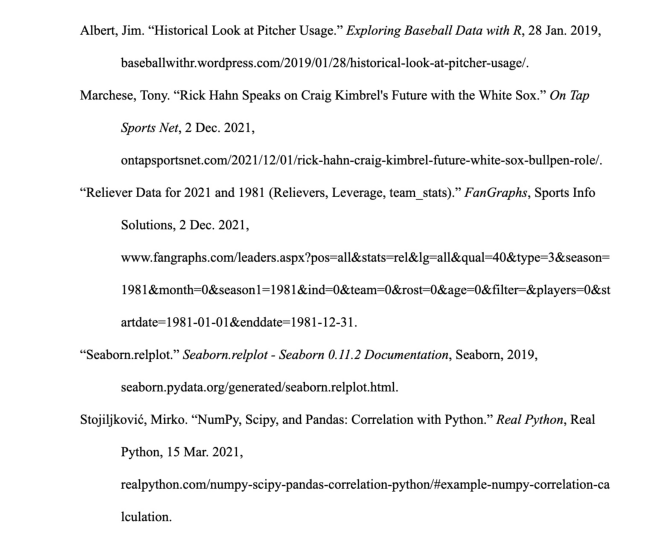

In [94]:
#references in MLA 8 format (photo attached, links provided below in seperate code block)
# all datasets were found from FanGraphs and were cited as one resource in the works cited page
references = Image.open('references.jpeg')
plt.figure(figsize = (20,10))
plt.imshow(references)
plt.axis('off')

Albert, Jim. “Historical Look at Pitcher Usage.” Exploring Baseball Data with R, 28 Jan. 2019, baseballwithr.wordpress.com/2019/01/28/historical-look-at-pitcher-usage/. 
Marchese, Tony. “Rick Hahn Speaks on Craig Kimbrel's Future with the White Sox.” On Tap Sports Net, 2 Dec. 2021, ontapsportsnet.com/2021/12/01/rick-hahn-craig-kimbrel-future-white-sox-bullpen-role/. 
“Reliever Data for 2021 and 1981 (Relievers, Leverage, team_stats).” FanGraphs, Sports Info Solutions, 2 Dec. 2021, www.fangraphs.com/leaders.aspx?pos=all&stats=rel&lg=all&qual=40&type=3&season=1981&month=0&season1=1981&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=1981-01-01&enddate=1981-12-31. 
“Seaborn.relplot.” Seaborn.relplot - Seaborn 0.11.2 Documentation, Seaborn, 2019, seaborn.pydata.org/generated/seaborn.relplot.html. 
Stojiljković, Mirko. “NumPy, Scipy, and Pandas: Correlation with Python.” Real Python, Real Python, 15 Mar. 2021, realpython.com/numpy-scipy-pandas-correlation-python/#example-numpy-correlation-calculation. 